In [7]:
import certifi
import os
os.environ['SSL-CERT_FILE'] = certifi.where()
from giza_datasets import DatasetsLoader


loader = DatasetsLoader()
df = loader.load("gora-competition-training")

Dataset gora-competition-training not found in cache. Downloading from GCS.
Dataset read from cache.


In [11]:
df = df.to_pandas()

In [25]:
forbidden =['total_liquidation', 'count_liquidation', 'avg_liquidation_amount', 'std_liquidation_amount', 'liquidation_amount_cv', 'avg_liquidation_to_avg_borrow', 'liquidated']

forbidden =['total_liquidation', 'count_liquidation', 'avg_liquidation_amount', 'std_liquidation_amount', 'liquidation_amount_cv', 'avg_liquidation_to_avg_borrow']
predictors_df = df[df.columns[~df.columns.isin(forbidden)]]


In [45]:
import numpy as np

commonly_borrowed_tokens_tokens = predictors_df.token_borrow_mode.str.lower().value_counts(normalize=True)[predictors_df.token_borrow_mode.str.lower().value_counts(normalize=True)*100>1].index

predictors_df['token_borrowed'] = np.where(predictors_df.token_borrow_mode.str.lower().isin(commonly_borrowed_tokens_tokens), predictors_df.token_borrow_mode.str.lower(), 'other')

predictors_df.drop('token_borrow_mode', axis=1, inplace=True)

/var/folders/3d/3_dbb7097rzc81cpv1mrh_nr0000gn/T/ipykernel_9541/4135649760.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictors_df['token_borrowed'] = np.where(predictors_df.token_borrow_mode.str.lower().isin(commonly_borrowed_tokens_tokens), predictors_df.token_borrow_mode.str.lower(), 'other')


In [58]:
predictors_df = predictors_df[['total_borrow', 'count_borrow', 'avg_borrow_amount',
       'std_borrow_amount', 'borrow_amount_cv',
       'total_repay', 'count_repay', 'avg_repay_amount', 'std_repay_amount',
       'repay_amount_cv', 'total_deposit', 'count_deposit',
       'avg_deposit_amount', 'std_deposit_amount', 'deposit_amount_cv',
       'total_redeem', 'count_redeem', 'avg_redeem_amount',
       'std_redeem_amount', 'redeem_amount_cv', 'days_since_first_borrow',
       'net_outstanding', 'int_paid', 'net_deposits',
       'count_repays_to_count_borrows', 'avg_repay_to_avg_borrow',
       'net_outstanding_to_total_borrowed', 'net_outstanding_to_total_repaid',
       'count_redeems_to_count_deposits', 'total_redeemed_to_total_deposits',
       'avg_redeem_to_avg_deposit', 'net_deposits_to_total_deposits',
       'net_deposits_to_total_redeemed', 'dex_total_sum_added',
       'dex_total_sum_removed', 'dex_total_sum_swapped', 'liquidated', 'token_borrowed']]

Training Loss: 0.0007164008806763412
Test Loss: 0.002012266940410958


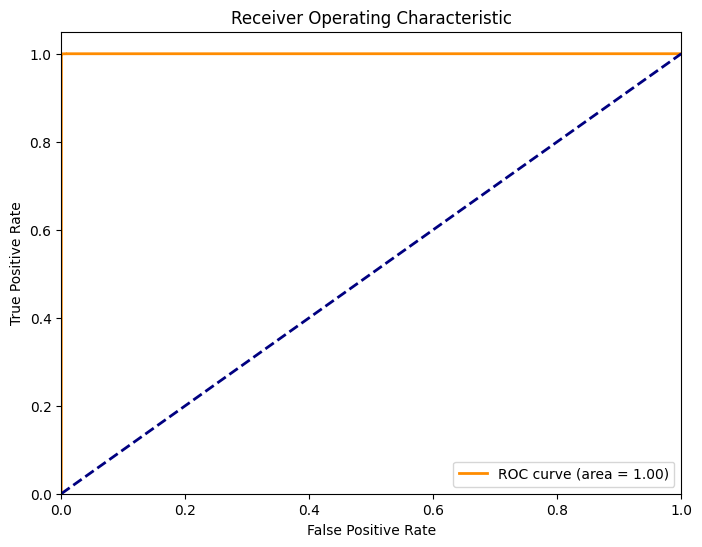

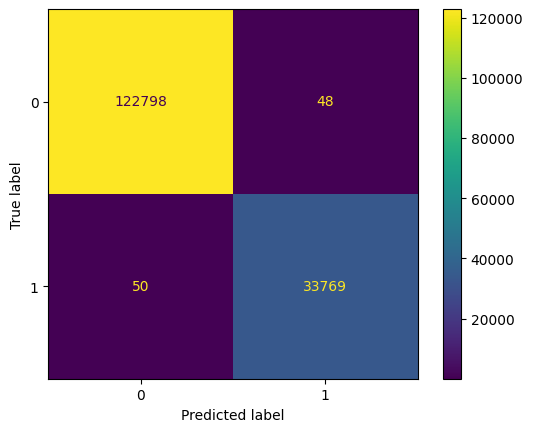

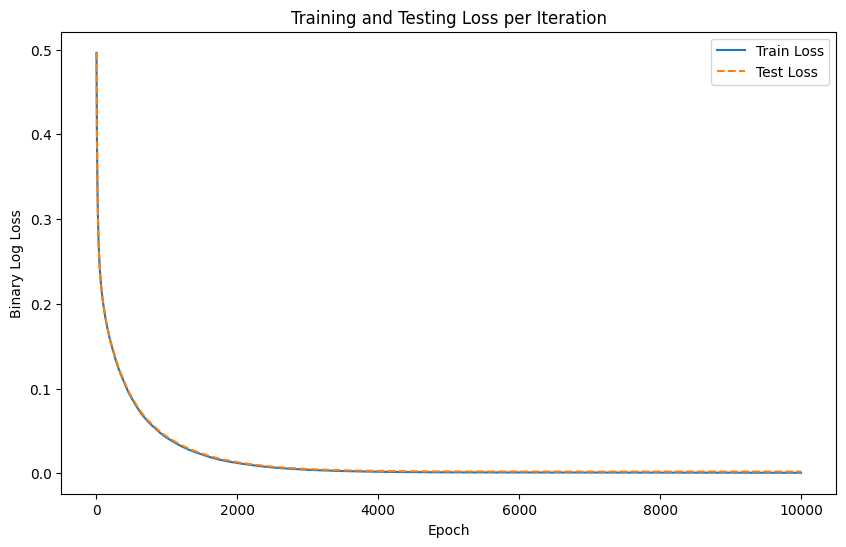

In [65]:
import pandas as pd

# Convert 'token_borrowed' column to dummies
# token_borrowed_dummies = pd.get_dummies(predictors_df['token_borrowed'], prefix='token')
# predictors_df = pd.concat([predictors_df, token_borrowed_dummies], axis=1)
# predictors_df.drop('token_borrowed', axis=1, inplace=True)

from sklearn.model_selection import train_test_split

# Separate features and target
X = predictors_df.drop('liquidated', axis=1)
y = predictors_df['liquidated']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import lightgbm as lgb

# Prepare the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for the LightGBM model
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
evals_result = {}

# Train the model with evaluation results
num_round = 10000
bst = lgb.train(params, train_data, num_round, valid_sets=[train_data, test_data], 
                valid_names=['train', 'test'], callbacks=[
                        #lgb.early_stopping(stopping_rounds=300), 
                        lgb.record_evaluation(evals_result)] )

from sklearn.metrics import log_loss

# Predict probabilities for the training and testing data
y_train_pred = bst.predict(X_train)
y_test_pred = bst.predict(X_test)

# Calculate the log loss for training and test sets
train_loss = log_loss(y_train, y_train_pred)
test_loss = log_loss(y_test, y_test_pred)

print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred > 0.5)  # Threshold of 0.5
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


import matplotlib.pyplot as plt

# Extract the log losses for both training and test sets
train_losses = evals_result['train']['binary_logloss']
test_losses = evals_result['test']['binary_logloss']

# Generate the epochs range
epochs = range(1, len(train_losses) + 1)

# Plotting the training and testing loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss', linestyle='--')
plt.title('Training and Testing Loss per Iteration')
plt.xlabel('Epoch')
plt.ylabel('Binary Log Loss')
plt.legend()
plt.show()